In [1]:
import os

import click
from os.path import  join, isdir
from plan import Plan
from action import Action
from utils import load_from_folder
from multiprocess import Pool


In [ ]:
save_dir = './results/'
data_base_dir = '../datasets/'
domain = 'satellite'
results_dir = f"{save_dir}/{domain}/"   
source_dir = f"{join(data_base_dir, domain)}/optimal_plans/plans_max-plan-dim=30_train_percentage=0.8" 
print('Domain dir:', source_dir)
os.makedirs(save_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)


Domain dir: ../datasets/logistics/optimal_plans/gr_dataset/dictionaries_and_plans/


Data load

In [54]:
splits = {}
train_plans = load_from_folder(source_dir,["train_plans"])
train_plans = train_plans[0]
val_plans = load_from_folder(source_dir,["val_plans"])
val_plans = val_plans[0]
test_plans = load_from_folder(source_dir,["test_plans"])
test_plans = test_plans[0]

splits["train_plans"] = train_plans
splits["val_plans"] = val_plans
splits["test_plans"] = test_plans


train_plans loaded from ../datasets/satellite/optimal_plans/plans_max-plan-dim=30_train_percentage=0.8
val_plans loaded from ../datasets/satellite/optimal_plans/plans_max-plan-dim=30_train_percentage=0.8
test_plans loaded from ../datasets/satellite/optimal_plans/plans_max-plan-dim=30_train_percentage=0.8


Data analysis

In [55]:
print(f"Train plans: {len(train_plans)}")
print(f"Val plans: {len(val_plans)}")
print(f"Test plans: {len(test_plans)}")

Train plans: 50236
Val plans: 6279
Test plans: 6281


In [56]:
for split in splits:
    print(f"{split}: Number of plans: {len(splits[split])}")        

train_plans: Number of plans: 50236
val_plans: Number of plans: 6279
test_plans: Number of plans: 6281


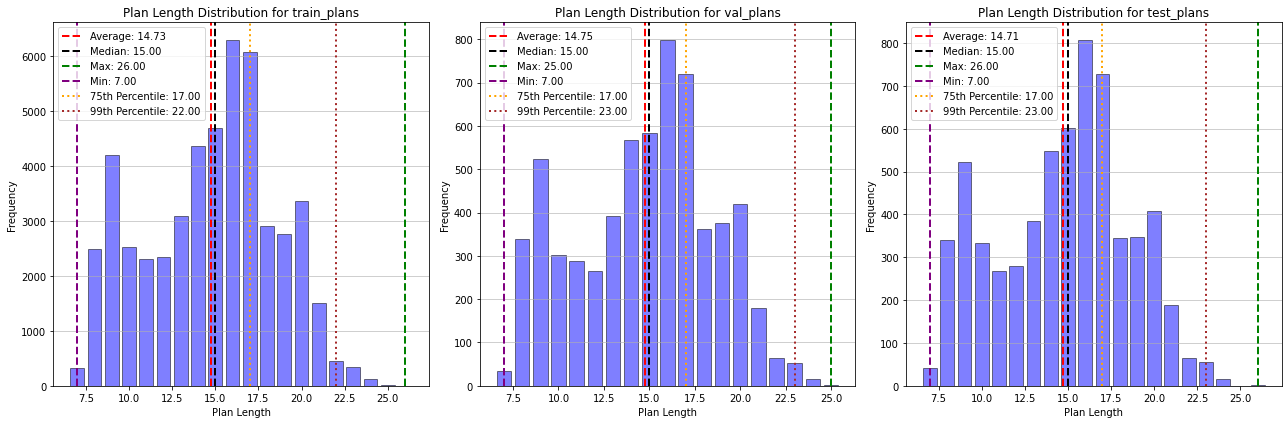

In [57]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(splits), figsize=(6 * len(splits), 6))
if len(splits) == 1:
    axs = [axs]
for ax, (split, plans) in zip(axs, splits.items()):
    plan_lengths = [len(plan.actions) for plan in plans]
    frequency = {}
    for length in plan_lengths:
        frequency[length] = frequency.get(length, 0) + 1
    avg_length_local = np.mean(plan_lengths)
    med_length_local = np.median(plan_lengths)
    max_length_local = np.max(plan_lengths)
    min_length_local = np.min(plan_lengths)
    perc75 = np.percentile(plan_lengths, 75)
    perc99 = np.percentile(plan_lengths, 99)
    ax.bar(frequency.keys(), frequency.values(), color='blue', alpha=0.5, edgecolor='black')
    ax.axvline(x=avg_length_local, color='red', linestyle='--', linewidth=2, label=f'Average: {avg_length_local:.2f}')
    ax.axvline(x=med_length_local, color='black', linestyle='--', linewidth=2, label=f'Median: {med_length_local:.2f}')
    ax.axvline(x=max_length_local, color='green', linestyle='--', linewidth=2, label=f'Max: {max_length_local:.2f}')
    ax.axvline(x=min_length_local, color='purple', linestyle='--', linewidth=2, label=f'Min: {min_length_local:.2f}')
    ax.axvline(x=perc75, color='orange', linestyle=':', linewidth=2, label=f'75th Percentile: {perc75:.2f}')
    ax.axvline(x=perc99, color='brown', linestyle=':', linewidth=2, label=f'99th Percentile: {perc99:.2f}')
    ax.set_title(f"Plan Length Distribution for {split}")
    ax.set_xlabel("Plan Length")
    ax.set_ylabel("Frequency")
    ax.grid(axis='y', alpha=0.75)
    ax.legend()
plt.tight_layout()
plt.savefig(f"{save_dir}/{domain}/{domain}_combined_plan_length_distribution.jpeg")
plt.show()

In [58]:
for split, plans in splits.items():
    print(f"Plan {plans[0].plan_name} for {split}:")
    for action in plans[0].actions:
        print(f"    {action.name}")
        print(f"        + : {action.positiveEffects}")
        print(f"        - : {action.negativeEffects}")
    print()

Plan /data/users/mchiari/WMCA/datasets/satellite/optimal_plans/xmls//xml-LPG-p013158.SOL for train_plans:
    SWITCH_ON INSTRUMENT1 SATELLITE3
        + : ['power_on instrument1']
        - : ['calibrated instrument1', 'power_avail satellite3']
    SWITCH_ON INSTRUMENT7 SATELLITE0
        + : ['power_on instrument7']
        - : ['calibrated instrument7', 'power_avail satellite0']
    TURN_TO SATELLITE4 STAR12 GROUNDSTATION1
        + : ['pointing satellite4 star12']
        - : ['pointing satellite4 groundstation1']
    TURN_TO SATELLITE3 PLANET10 PLANET9
        + : ['pointing satellite3 planet10']
        - : ['pointing satellite3 planet9']
    CALIBRATE SATELLITE3 INSTRUMENT1 PLANET10
        + : ['calibrated instrument1']
        - : []
    TURN_TO SATELLITE0 STAR0 PLANET8
        + : ['pointing satellite0 star0']
        - : ['pointing satellite0 planet8']
    CALIBRATE SATELLITE0 INSTRUMENT7 STAR0
        + : ['calibrated instrument7']
        - : []
    TURN_TO SATELLITE0 PHENO

In [59]:
for split, plans in splits.items():
    for plan in plans[:3]:
        print(f"Goals {plan.goals}:")
        print()

Goals ['have_image phenomenon8 spectrograph0', 'have_image star12 infrared3', 'have_image star0 infrared0', 'have_image phenomenon4 image4', 'have_image planet10 infrared3', 'have_image star5 spectrograph0', 'pointing satellite3 planet10', 'pointing satellite4 star12', 'pointing satellite0 groundstation1']:

Goals ['have_image star16 spectrograph1', 'have_image planet4 image3', 'have_image planet12 spectrograph1', 'have_image star5 image3', 'have_image star7 image4', 'pointing satellite1 star15', 'pointing satellite2 phenomenon8']:

Goals ['have_image phenomenon6 spectrograph2', 'have_image star9 image2', 'have_image phenomenon5 spectrograph2', 'have_image phenomenon4 image2', 'have_image star12 image3', 'pointing satellite0 phenomenon14', 'pointing satellite2 star2']:

Goals ['have_image star5 image2', 'have_image star1 infrared3', 'have_image groundstation0 image2', 'have_image star2 image2', 'have_image star3 infrared3', 'pointing satellite2 groundstation0', 'pointing satellite0 phe

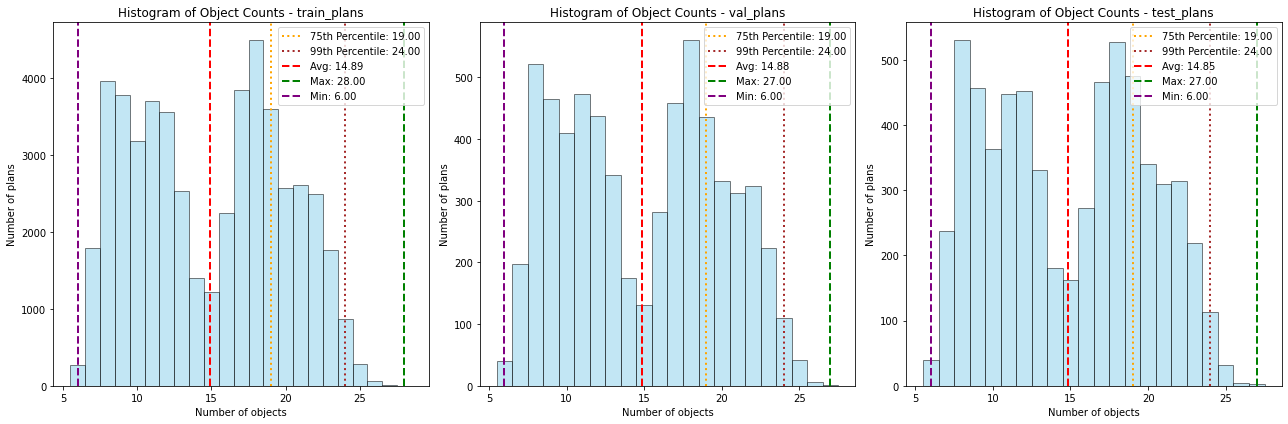

In [60]:
# counting plan init objects,
# how can i know all objects in the domain without the domain?
# try to explore the plan to find all objects involved
    
# create a combined figure with subplots for object count histograms
fig, axs = plt.subplots(1, len(splits), figsize=(6 * len(splits), 6))
if len(splits) == 1:
    axs = [axs]

for ax, (split, plans) in zip(axs, splits.items()):
    obj_numbers_list = []
    for plan in plans:
        obj_set = set()
        for text in plan.initial_state:
            for obj in text.split(" ")[1:]:
                obj_set.add(obj)
        for action in plan.actions:
            for fluent in action.positiveEffects:
                for obj in fluent.split(" ")[1:]:
                    obj_set.add(obj)
            for fluent in action.negativeEffects:
                for obj in fluent.split(" ")[1:]:
                    obj_set.add(obj)
        obj_numbers_list.append(len(obj_set))
        
    bins = np.arange(min(obj_numbers_list), max(obj_numbers_list) + 2, 1)
    # bins = 20 #for logistics
    ax.hist(obj_numbers_list, bins=bins, color='skyblue', edgecolor='black', alpha=0.5, align='left')
    avg_val = np.mean(obj_numbers_list)
    max_val = np.max(obj_numbers_list)
    min_val = np.min(obj_numbers_list)
    perc75 = np.percentile(obj_numbers_list, 75)
    perc99 = np.percentile(obj_numbers_list, 99)
    ax.axvline(x=perc75, color='orange', linestyle=':', linewidth=2, label=f'75th Percentile: {perc75:.2f}')
    ax.axvline(x=perc99, color='brown', linestyle=':', linewidth=2, label=f'99th Percentile: {perc99:.2f}')
    ax.axvline(x=avg_val, color='red', linestyle='--', linewidth=2, label=f'Avg: {avg_val:.2f}')
    ax.axvline(x=max_val, color='green', linestyle='--', linewidth=2, label=f'Max: {max_val:.2f}')
    ax.axvline(x=min_val, color='purple', linestyle='--', linewidth=2, label=f'Min: {min_val:.2f}')

    ax.set_title(f"Histogram of Object Counts - {split}")
    ax.set_xlabel("Number of objects")
    ax.set_ylabel("Number of plans")
    ax.legend()
plt.tight_layout()
plt.savefig(f"{save_dir}/{domain}/{domain}_combined_obj_count_histogram.jpeg")
plt.show()